In [1]:
import numpy as np

from scipy.optimize import minimize

import sys, pathlib
sys.path.insert(0, str(pathlib.Path.cwd().parent))

from src.variational import SingleParameterAnsatz, Ansatz
from src.utils import set_seeds, fidelity, gaussian_state


  ------ Initial State Preparation ------

Optimal λ parameters: [-1.1236369]
Final fidelity: 0.4188162406320026


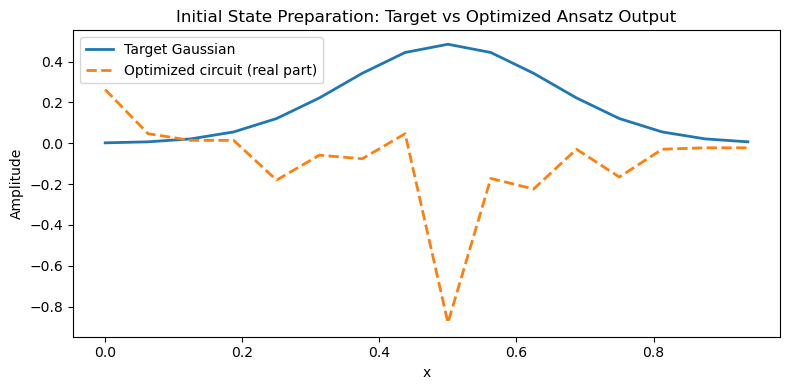

In [ ]:
n_qubits = 4           # grid size N = 2^n
depth = 2              # ansatz layers

set_seeds(42)

# Prepare initial state: Gaussian 
ansatz = SingleParameterAnsatz(n_qubits, depth)
target = gaussian_state(n_qubits, domain=[(0.0, 1.0)])
init_param = ansatz.random_param()
res = minimize(fidelity, init_param, args=(ansatz, target),
            method="COBYLA", options={"maxiter": 200})

lambda1 = res.x
print("\n  ------ Initial State Preparation ------\n")
print("Optimal λ parameters:", res.x)
print("Final fidelity:", -res.fun)

# --- Plot target vs optimized circuit output ---
from qiskit.quantum_info import Statevector
from qiskit import transpile
from qiskit_aer import Aer

# Get optimized statevector (as in fidelity)
qc = ansatz.qc(lambda1)
backend = Aer.get_backend("statevector_simulator")
sv = Statevector.from_instruction(transpile(qc, backend))
psi_opt = sv.data  # complex amplitudes

# Plot
xs = np.linspace(0, 1, 2**n_qubits, endpoint=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(xs, target, label="Target Gaussian", lw=2)
plt.plot(xs, np.real(psi_opt), label="Optimized circuit (real part)", lw=2, linestyle="--")
plt.xlabel("x")
plt.ylabel("Amplitude")
plt.title("Initial State Preparation: Target vs Optimized Ansatz Output")
plt.legend()
plt.tight_layout()
plt.show()


  ------ Initial State Preparation ------

Optimal λ parameters: [ 2.85247     2.86079981 -0.25852745 -5.13027394 -1.50252295 -4.67355474
  1.20784738  1.80452042]
Final fidelity: 0.9948486658377701


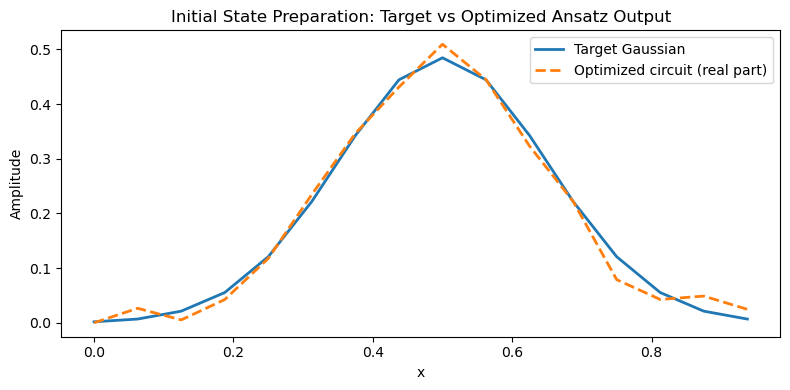

In [ ]:
n_qubits = 4           # grid size N = 2^n
depth = 2              # ansatz layers

# Prepare initial state: Gaussian 
ansatz = Ansatz(n_qubits, depth)
target = gaussian_state(n_qubits, domain=[(0.0, 1.0)])
init_params = ansatz.random_params()
res = minimize(fidelity, init_params, args=(ansatz, target),
            method="COBYLA", options={"maxiter": 200})

lambda1 = res.x
print("\n  ------ Initial State Preparation ------\n")
print("Optimal λ parameters:", res.x)
print("Final fidelity:", -res.fun)

# --- Plot target vs optimized circuit output ---
from qiskit.quantum_info import Statevector
from qiskit import transpile
from qiskit_aer import Aer

# Get optimized statevector (as in fidelity)
qc = ansatz.qc(lambda1)
backend = Aer.get_backend("statevector_simulator")
sv = Statevector.from_instruction(transpile(qc, backend))
psi_opt = sv.data  # complex amplitudes

# Plot
xs = np.linspace(0, 1, 2**n_qubits, endpoint=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(xs, target, label="Target Gaussian", lw=2)
plt.plot(xs, np.real(psi_opt), label="Optimized circuit (real part)", lw=2, linestyle="--")
plt.xlabel("x")
plt.ylabel("Amplitude")
plt.title("Initial State Preparation: Target vs Optimized Ansatz Output")
plt.legend()
plt.tight_layout()
plt.show()